# Text Mining - Document Summary

History:

- 2017/9/7: 
    - 移除文章內的google廣告語法
    - 用逗號和問號斷句
    - 加入similar words
        - check read01_summary
    - 加入兩張圖(tf-idf keywords, similar words)
        - check keywordmap
- 2017/9/11:
    - 建立user dict
    - 用jieba抓tfidf key words
- 2017/9/12:
    - word2vec
    - pca, tsne for visualization
    - LDA

  

Reference:
- 用scikit-learn学习LDA主题模型
    - http://www.cnblogs.com/pinard/p/6908150.html
    - http://blog.csdn.net/eastmount/article/details/50824215
    
- 中文文本挖掘预处理流程总结
    - http://www.cnblogs.com/pinard/p/6744056.html
    
- Mining English and Korean text with Python
    https://www.lucypark.kr/courses/2015-ba/text-mining.html
    
- NLTK (POS, chunk, Parser tree)    
    - http://aweiho2015.pixnet.net/blog/post/10269587-%5B%E8%AA%8D%E8%AD%98%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%28text-mining%29%5D--%E5%A6%82%E4%BD%95%E8%99%95%E7%90%86%E4%B8%80%E5%8F%A5
    
- TF-IDF and TextRank
    - http://zhicongchen.github.io/2016/11/22/TF-IDF-and-TextRank/
    
- 中文斷詞：斷句不要悲劇 / Head first Chinese text segmentation    
    - https://speakerdeck.com/fukuball/head-first-chinese-text-segmentation

In [25]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import re
import ast

import random
from flask import Flask, g, render_template, request
import logging
import html_template as ht
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import collections
import pickle

from collections import OrderedDict
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

pd.set_option('display.max_columns', None)
punct = u'''\n +-％%:!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳丨﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘—_…~/#><'''
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('userdict.txt')

/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Building prefix dict from /Users/jayhsu/work/github/textmining/dict.txt.big ...
Loading model from cache /var/folders/yf/hq7ghg4j3ksb8k34wyh8vk2m0000gn/T/jieba.ub36e993abda9bbf53d1f5b38e3ae9b44.cache
Loading model cost 2.584 seconds.
Prefix dict has been built succesfully.


In [14]:
fp = matplotlib.font_manager.FontProperties(fname = 'font/NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

stpwrdpath = "model/stop_words.txt"
stpwrd_dic = open(stpwrdpath, 'r')
stpwrd_content = stpwrd_dic.read()
stpwrdlst = stpwrd_content.splitlines()
stpwrd_dic.close()

In [15]:
def sort2list(list1, list2):
    list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2),reverse=True)))
    return list1, list2

def keywords(row, voc_dic, kwtopn=3, withWeight=False):
    keywork_list=[]
    keyworkWweight_list=[]
    tfidf_vec = row['tfidf_vector']
    topn = list(set(tfidf_vec))
    topn.sort(reverse=True)
    for top in topn[:kwtopn]:
        if top==0:
            continue
        winner = np.argwhere([x ==top for x in tfidf_vec ])
        idxlist =winner.flatten().tolist() 
        for i in idxlist:
            keywork_list.append(voc_dic.get(i))
            keyworkWweight_list.append((voc_dic.get(i), top)  )
        if len(keywork_list)>=kwtopn:
            break
    if withWeight:
        return tuple(keyworkWweight_list) 
    else:
        return tuple(keywork_list) 
    


def docsummary(row):
    doc_list = row['sentences']
    keywords = row['keywords']
    if keywords:
        keysentencelist=[]
        for doc in doc_list:
            doc = doc.lower()
            for kw in keywords:
                if kw in doc and doc not in keysentencelist:
                    keysentencelist.append(doc)
                    
        #summary_str = ','.join(keysentencelist)
        summary_str=''
        strlen = 0
        for sen in keysentencelist[:10]:
            if strlen>50:
                strlen = len(sen)
                summary_str=summary_str+',\n'+sen
            else:
                strlen = strlen + len(sen)
                summary_str=summary_str+','+sen
    else:
        summary_str='NA'
        
    return summary_str


In [35]:
exlist=['adsbygoogle','...']
def read01_summary(folder, topic, kw_topn=3):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            if not len(line):                               
                continue                                    
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+'_'+fname)

    dl_df = pd.DataFrame({'fname':fileName, 'doc_tmp':docs})
    dl_df.sort_values(by='fname')
    dl_df['sentences']=dl_df['doc_tmp'].map(lambda x: re.split("[\n\r，。？]+", x))
    dl_df['sentences']=dl_df['sentences'].map(lambda x: [s for s in x if not any(w in s for w in exlist)])    
    dl_df['doc']=dl_df['sentences'].map(lambda x: '\n'.join(x))
    dl_df['words'] =   dl_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct]) 
    dl_df['words_str'] = dl_df['words'].map(lambda x: ' '.join(x))

    cv = CountVectorizer(stop_words=stpwrdlst)
    vecs1 = cv.fit_transform(dl_df['words_str']).toarray()
    
    doclen= list(dl_df['words'].map(lambda x:len(x)))
    tf_vec = [(a/b).tolist() for a,b in zip(vecs1.tolist(), doclen)]
    dl_df['tf_vector'] = tf_vec
    fea = cv.get_feature_names()
    key = range(len(fea))
    voc_dic = dict(zip(key, fea))
    vockey_dic = dict(zip(fea, key))
    tfidf = TfidfTransformer()
    vecs2 = tfidf.fit_transform(vecs1).toarray()
    dl_df['tfidf_vector'] = [_ for _ in vecs2]
    
    dl_df['keywords'] = dl_df.apply(keywords, axis=1, args=(voc_dic,kw_topn,False))
    dl_df['keywords'] = dl_df['keywords'].map(list)
    dl_df['keywords_w'] = dl_df.apply(keywords, axis=1, args=(voc_dic,kw_topn,True))
    
    #dl_df['keywords_jb'] = dl_df['doc'].map(lambda x: jieba.analyse.tfidf(x,topK=kw_topn, withWeight=True))
    #dl_df['keywords_jb'] = dl_df['keywords_jb'].map(list)
    #dl_df['summary'] = dl_df.apply(docsummary, axis=1)
    
    dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)
    
    all_keywords = sum(list(dl_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    
    return dl_df, voc_dic,vockey_dic, dl_w2v_model, dl_pca

def keywordmap(lyrics_df, idx, w2v_model,pca,voc_dic, kw_size=30):
    figures=[]
    all_keywords = sum(list(lyrics_df['keywords']),[])
    counter = collections.Counter(all_keywords)
    if len(set(all_keywords)) <100:
        samples = len(set(all_keywords))
    else:
        samples = 100
    topn_keywords = [w[0] for w in counter.most_common(samples)]
    this_keyword = lyrics_df['keywords'][idx]

    vec = np.array([w2v_model[w] for w in (topn_keywords+this_keyword)])

    vec_pca = pca.transform(vec)
    topn_pca = vec_pca[:samples]
    this_pca = vec_pca[samples:]

    tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000)
    lowdim_embs = tsne.fit_transform(vec_pca)

    topn_lowdim_embs = lowdim_embs[:samples]
    this_lowdim_embs = lowdim_embs[samples:]
    
    plt.clf()
    fig = plt.figure(figsize=(20,10))
    figures.append(fig)
    plt.subplot(121)
    plt.scatter(topn_lowdim_embs[:, 0], topn_lowdim_embs[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_lowdim_embs[:, 0], this_lowdim_embs[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA + T-SNE')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')
    
    
    plt.subplot(122)
    plt.scatter(topn_pca[:, 0], topn_pca[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_pca[:, 0], this_pca[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')


    fig2 = plt.figure(figsize=(15,6))
    figures.append(fig2)
    tfidf_vec = lyrics_df['tfidf_vector'][idx]
    topn_vec , topn_word= sort2list(list(tfidf_vec) , list(voc_dic.values()))
    plt.bar(range(len(topn_vec[:kw_size])), topn_vec[:kw_size])
    plt.xticks(range(len(topn_vec[:kw_size])), topn_word[:kw_size],rotation=60, fontsize=12)
    plt.title('tfidf keywords')
    #print(topn_word[:n])
    #plt.show()
    
    for kw in lyrics_df['keywords'][idx]:
        fig3 = plt.figure(figsize=(15,6))
        figures.append(fig3)
        similarwords = w2v_model.most_similar(kw, topn=kw_size)
        words, similarity = zip(*similarwords)
        barlist = plt.bar(range(len(similarity)), similarity)
        plt.xticks(range(len(similarity)), words,rotation=60, fontsize=12)
        plt.title('similar word of {kw}'.format(kw=kw))
        #barlist[0].set_color('r')
        #print(words)
        #plt.show()
    return figures


***
***

** 一篇文章分析 ** 

In [36]:
dl_df, dl_voc_dic, dl_vockey_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic='深度學習',kw_topn=50)


** 1. 檢查斷詞效果 **

In [22]:
docid=13
print('斷詞:')
#print(', '.join(list(dl_df['words'][docid])))

斷詞:


 - 把需要修正的詞加入自訂義字典 
 - 紀錄load_userdict後仍然斷錯的

** 2. extract key words **

 - TF-IDF (IDF: 100篇read01的深度學習文章)

In [52]:
keywords_predefined = ['NVIDIA', '黃仁勛', 'GPU', '深度學習']

keywords:


,keyword,tfidf,tf
0,digits,0.399,0.017615
1,titan,0.277,0.012195
2,devbox,0.236,0.008130
3,nvidia,0.195,0.010840
4,深度神經網絡,0.177,0.012195
5,gpu,0.170,0.014905


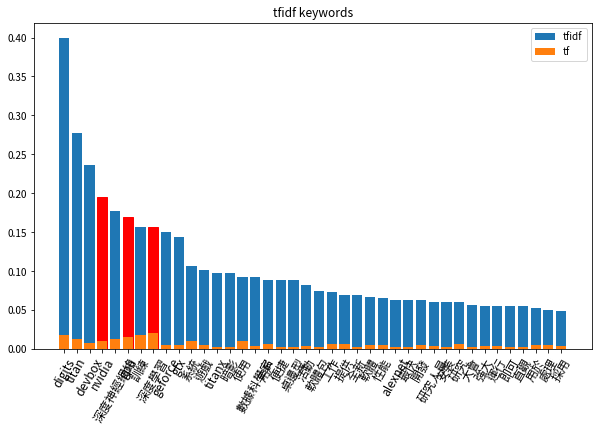

In [57]:
print('keywords:')
#print(', '.join(list(v['keywords'][docid])))
kw_x, kw_y = zip(*(dl_df['keywords_w'][docid][:40]))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))


tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x]])
display(tfidf_df[:6])

plt.figure(figsize=(10,6))
barlist = plt.bar(range(len(kw_y)), kw_y, label='tfidf')
plt.bar(range(len(kw_y)), tfidf_df['tf'], label='tf')
plt.xticks(range(len(kw_x)), kw_x,rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')

for idx, kw in enumerate(kw_x):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')
#barlist


 - TF-IDF (IDF: jieba內建語料庫)

keywords_jb:


,keyword,tfidf,tf
0,深度學習,0.348,0.020325
1,訓練,0.301,0.017615
2,DIGITS,0.301,0.017615
3,GPU,0.255,0.014905
4,深度神經網絡,0.209,0.012195
5,TITAN,0.209,0.012195


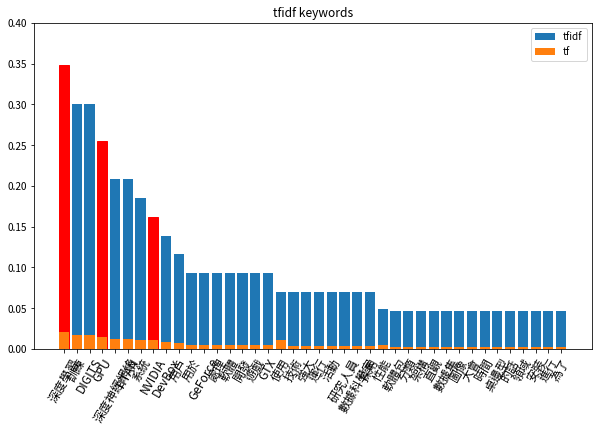

In [61]:
print('keywords_jb:')
kw_x, kw_y = zip(*jieba.analyse.tfidf(dl_df['doc'][docid],topK=100, withWeight=True))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))

tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x.lower()]])
display(tfidf_df[:6])

plt.figure(figsize=(10,6))
xtmp=range(len(kw_y[:40]))
barlist = plt.bar(xtmp, kw_y[:40], label='tfidf')
plt.bar(xtmp, tfidf_df['tf'][:40], label='tf')
plt.xticks(xtmp, kw_x[:40],rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')
plt.ylim(0,0.4)


for idx, kw in enumerate(kw_x[:40]):
    if kw.upper() in keywords_predefined:
        barlist[idx].set_color('r')
#barlist


**3. Topic **

  - word2vec word similarity 

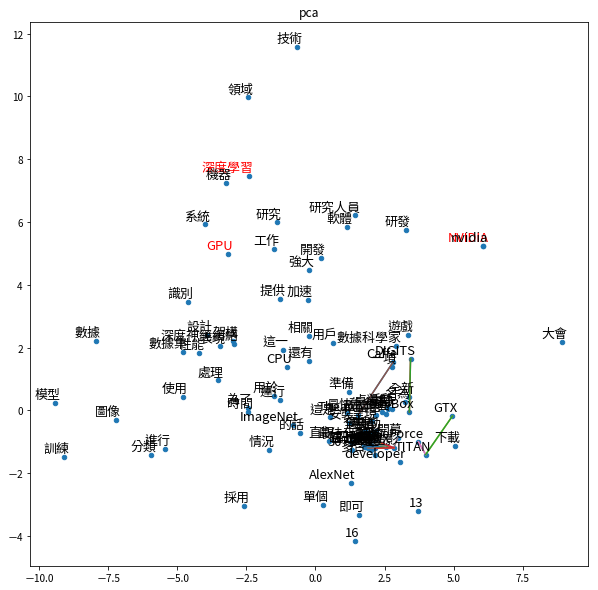

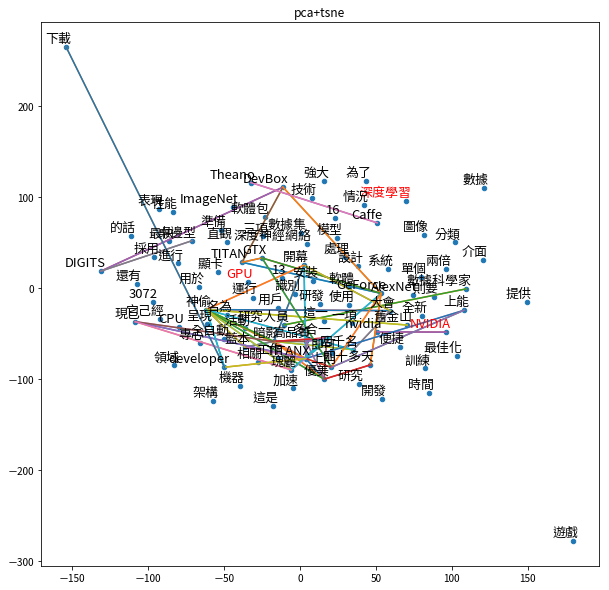

In [46]:
kw_x = jieba.analyse.tfidf(dl_df['doc'][docid],topK=100, withWeight=False)
#kw_x = jieba.analyse.textrank(dl_df['doc'][docid],topK=100, withWeight=False)
vec_kw = [list(dl_w2v_model[w.lower()]) for w in kw_x]

vec_pca = dl_pca.transform(vec_kw)
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000,)
vec_tsne = tsne.fit_transform(vec_pca)

plt.clf()
fig = plt.figure(figsize=(10,10))
plt.scatter(vec_pca[:, 0], vec_pca[:, 1], s= 20, label='top 100 words')
for i, label in enumerate(kw_x):
    x, y = vec_pca[i][:2]
    if label in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_pca[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_pca[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.7):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca')
    
    
fig = plt.figure(figsize=(10,10))
plt.scatter(vec_tsne[:, 0], vec_tsne[:, 1], s= 20, label='top 100 words')
for i, label in enumerate(kw_x):
    x, y = vec_tsne[i][:2]
    if label in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_tsne[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_tsne[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.6):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca+tsne')

In [ ]:

X = np.array(list(df0['tfidf_vector'].values))
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
df0['kmeans_group'] = kmeans.predict(X)
df0[['kmeans_group', 'doc']]

# show groups
df0['left_100'] = df0['doc'].map(lambda x: x[:100])
df0.groupby(['kmeans_group', 'left_100']).size().reset_index()


X2= np.array(list(df0['w2v_vector_avg'].values))
w2vkmeans = KMeans(n_clusters=4, random_state=0).fit(X2)
df0['w2v_kmeans_group'] = w2vkmeans.predict(X2)


- LDA 

/Users/jayhsu/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,sentence:,topic
0,【 IT168 資訊 】 為了 解決 當今世界 最 尖端 的 技術 挑戰 之一 ， NVIDIA 剛剛 推出 了 全新 的 硬體 和 軟體 ， 將 前所未有 地 提高 深度學習 研究 的 速度 、 易用性 和 功用 。,0
23,它己經 預先 安裝 了 數據科學家 和 研究人員 在 開發 自己 的 深度神經網絡 時 ， 所 需要 使用 到 的 各種 軟體 ， 包括 DIGITS 軟體包 、 最 受歡迎 的 深度學習 架構 一 Caffe 、 Theano 和 Torch ， 還有 NVIDIA 完整 的 GPU 加速 深度學習 庫 cuDNN 2.0 。,0
21,NVIDIA 深度學習 工程團隊 為了 自己 的 研發 工作 而 開發 的 DIGITS DevBox ， 是 一套 集 多項 功能 於 一身 的 平台 ， 能夠 加快 深度學習 的 研究 活動 。,0
17,DIGITS 可 在 安裝 、 配置 和 訓練 深度神經網絡 過程 中為 用戶 提供 指導 一 處理 複雜 的 工作 好 讓 科學家 能 專心 在 研究 活動 和 結果 上 。,0
7,TITANX 是 NVIDIA 全新 推出 的 旗艦級 遊戲 顯卡 ， 但 也 特別 適合 用於 深度學習 。,0
13,DIGITS ： 通往 最佳 深度神經網絡 的 便捷 之 路,0
6,GeForce GTX TITAN X 的 另一面,1
24,所有 這些 都 集結 在 這個 高 能效 、 靜默 、 運行 流暢 且 外形 優美 的 軟體包 中 ， 只 需要 普通 的 電源插座 ， 低調 安置 在 您 的 桌下 即可 。,1
20,DIGITS DevBox ： 全球 最快 的 桌邊型 深度學習 機器,2
19,這是 同類 系統 中 首個 提供 實時監控 和 可視化 功能 的 系統 ， 用戶 可以 對 工作 進行 微調 。 它還 支持 GPU 加速 版本 Caffe ， 目前 ， 這一 框架 在 眾多 數據科學家 和 研究人員 中 都 得到 了 廣泛 使用 ， 用於 構建 神經網絡 。,2


,0,1,2,3,4
0,"(3.49489573181, 深度學習)","(1.22785760951, geforce)","(3.04362237859, 訓練)","(3.00323630461, gpu)","(3.31498183514, google)"
1,"(2.52856030506, nvidia)","(1.20498234239, 安置)","(2.56680948759, 系統)","(2.54261088334, titan)","(2.08508015122, 用戶)"
2,"(2.48573560714, digits)","(1.19428450073, 這些)","(2.43293347798, digits)","(2.4737541071, 使用)","(2.07695779156, 深度學習)"
3,"(2.14959049704, 研究)","(1.14574194333, 即可)","(2.09122140397, titan)","(2.46710495739, 訓練)","(2.02004850646, 系統)"
4,"(2.10085092692, 深度神經網絡)","(1.13855091041, 集結)","(2.04648963505, 深度神經網絡)","(2.42120294443, 性能)","(2.00112479034, digits)"
5,"(1.61418017611, 自己)","(1.13716839544, 另一面)","(2.04135571848, 深度學習)","(2.0682132429, google)","(1.97869260309, 訓練)"


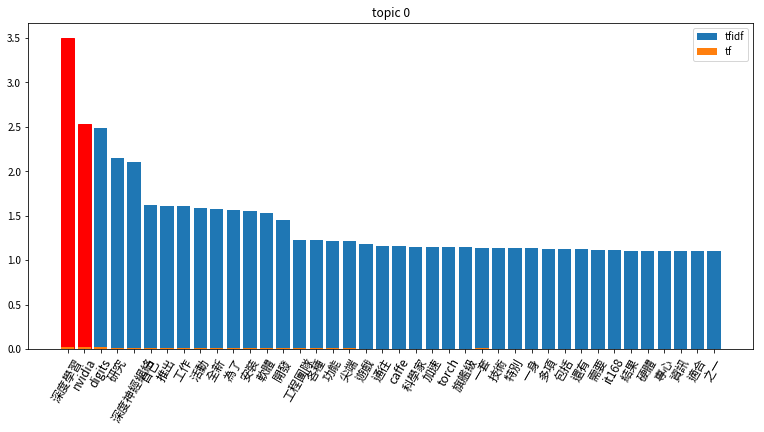

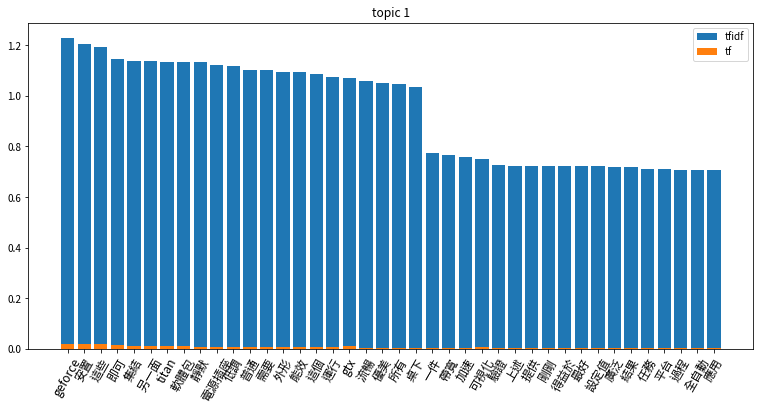

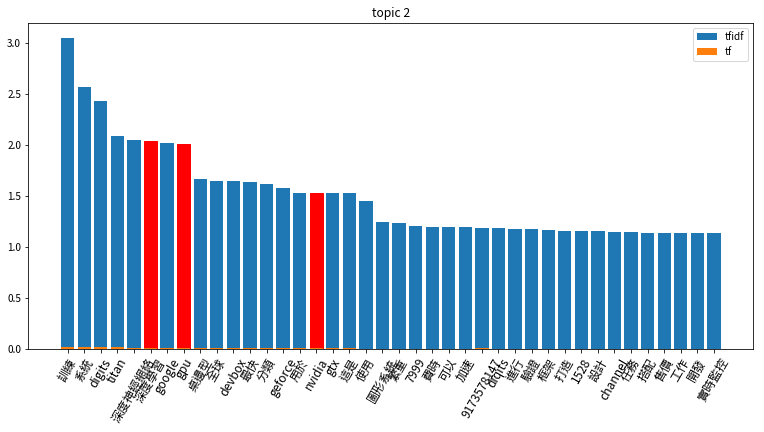

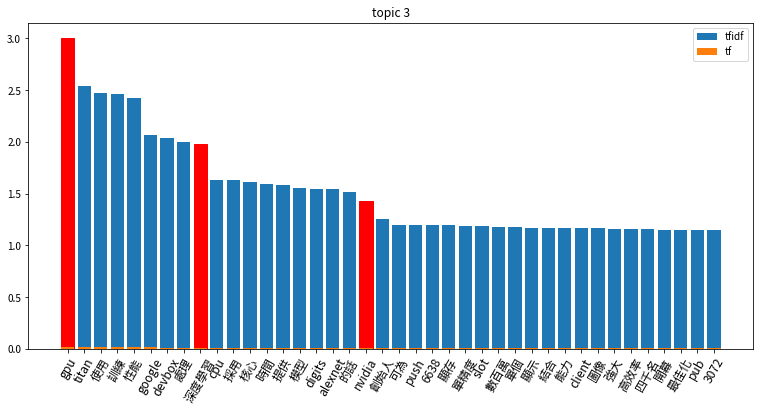

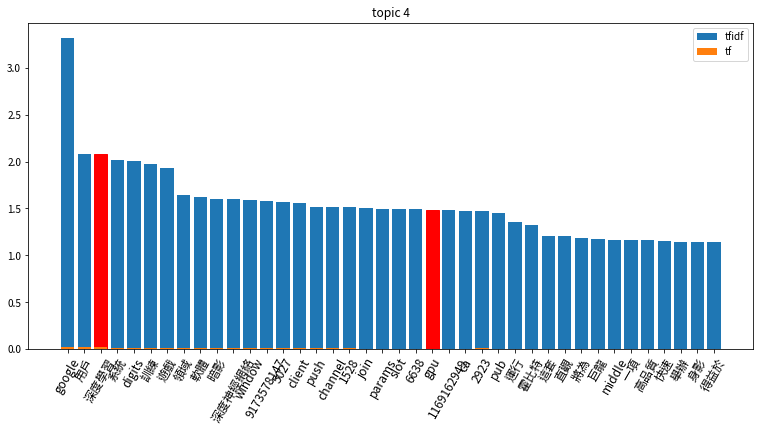

In [81]:
topic_num = 5
doc = dl_df['doc_tmp'][13]
paragraph = doc.split('\n')

paragraph_cutstrlist=[]
for p in paragraph:
    if p =='...':
        continue
    p_cut = jieba.cut(p)
    p_cut_str = ' '.join(p_cut)
    paragraph_cutstrlist.append(p_cut_str)
    

cntVector = CountVectorizer(stop_words=stpwrdlst)
cntTf = cntVector.fit_transform(paragraph_cutstrlist)
fea = cntVector.get_feature_names()
lda = LatentDirichletAllocation(n_topics=topic_num,
                                learning_offset=50.,
                                random_state=0)
docres = lda.fit_transform(cntTf)

topiclist = np.argmax(docres, axis=1)
doc_topic = pd.DataFrame({ 'sentence:':paragraph_cutstrlist,'topic':topiclist})
display(doc_topic.sort_values(by='topic'))


lda_kwlist= []
for i in lda.components_:
    kw, weight = sort2list(i, fea)
    lda_kwlist.append(list(zip(kw,weight)))
topic_kw = pd.DataFrame(lda_kwlist)
topic_kw = topic_kw.transpose()
display(topic_kw[:6])


for i in range(topic_num):
    kw_y, kw_x,  = zip(*topic_kw[i])
    kw_y = list(map(lambda x: float('%.3f'% x),kw_y))

    plt.figure(figsize=(13,6))
    xtmp=range(len(kw_y[:40]))
    barlist = plt.bar(xtmp, kw_y[:40], label='tfidf')
    plt.bar(xtmp, tfidf_df['tf'][:40], label='tf')
    plt.xticks(xtmp, kw_x[:40],rotation=60, fontsize=12)
    plt.legend()
    plt.title('topic {n}'.format(n=i))
    #plt.ylim(0,0.4)

    for idx, kw in enumerate(kw_x[:40]):
        if kw.upper() in keywords_predefined:
            barlist[idx].set_color('r')


***

***
***
** flask web **

urls = [
    ['', '', '/', '']
    , ['deeplearningSummary', 'docid,topic', '/deeplearningSummary/0/4', 'test']
]
df_url = pd.DataFrame(urls, columns=['page', 'ps', 'instance', 'remark']).set_index('page')
df_url['instance'] = df_url['instance'].map(lambda x: '<a href="%s">%s</a>'%(x, x) if x != '' else '')


app = Flask(__name__)

def get_ps(page, path):
    names = df_url.ix[page]['ps'].split(',')
    try:
        ps = {k: v for k, v in zip(names, path.split('/'))}
    except:
        ps = {}
    return ps

def get_route(df_url, page):
    return '/%s'%page + ''.join(['/<%s>'%_ for _ in df_url.ix[page]['ps'].split(',') if len(_)>0 ])

@app.route('/')
def root(**ps):    
    cards = [['URL', [['table', df_url.reset_index()[['page', 'instance', 'ps', 'remark']]]] ]]
    try:
        texts = ['hi, %s'%flask_login.current_user.id]
    except:
        texts = []
    return ht.HtmlTemplate('Root', cards=cards, texts=texts).to_html()


topic_list=[w for w in os.listdir('text_dl') if not w.startswith('.')]
topic=-1
dl_df=None
dl_w2v_model=None
dl_pca=None
dl_voc_dic=None
@app.route('/deeplearningSummary/<path:path>')
def deeplearningSummary(path=''):
    global topic
    global dl_df
    global dl_w2v_model
    global dl_pca
    global dl_voc_dic
    #print(path)
    ps={}
    ps = get_ps('deeplearningSummary', path)
    #print(ps)
    docid = int(ps.get('docid'))  #docid
    topic_new = int(ps.get('topic'))  #topic
    print(topic_new)
    topic_str = topic_list[topic_new]
    
    if topic!=topic_new:
        dl_df, dl_voc_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic=topic_str, kw_topn=50)
        tipic=topic_new
    
    selected_doc = dl_df.ix[docid]
    
    cards = []
    content=[]
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_doc[col]])
    
    similarwords=OrderedDict()
    for kw in list(dl_df['keywords'][0]):
        similarword=dl_w2v_model.most_similar(kw,topn=20)
        similarwords[kw]=similarword
    similarwords_df = pd.DataFrame(similarwords)
    content.append(['text', '<font color="blue">{col}</font>'.format(col='similar words')])
    content.append(['table',similarwords_df])
    
    content.append(['text', '<font color="blue"> Text Summary</font>'])
    content.append(['table', dl_df[['fname','keywords','summary']]])
    
    cards.append(['text summary', content ])
    
    figs = keywordmap(dl_df, docid, dl_w2v_model, dl_pca,dl_voc_dic, kw_size=50)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='docid', text='doc', options=list(range(dl_df.shape[0])), value=docid, labels=list((dl_df['fname'])) ))
    controls.append( ht.Control_Select(id='topic', text='topic', options=list(range(len(topic_list))), value=topic_new, labels=topic_list ))
    
    return ht.HtmlTemplate('Text Summary App', ps, cards, controls=controls, page='deeplearningSummary').to_html()


if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5001)


***
** 下面都沒用 **